# Churn Distribution Analysis Notebook

## Overview
This notebook analyzes churn distribution across different feature types to understand which factors correlate with customer churn.

### Analysis Agenda:
1. **Overall Churn Distribution** - Baseline churn rate and patterns
2. **Demographic Features** - Age, gender, marital status, dependents
3. **Service Features (Binary)** - Yes/No service subscriptions
4. **Service Features (Continuous)** - Numerical service metrics  
5. **Service Features (Ordinal)** - Categorical features with order


### Key Objectives:
- Identify statistically significant differences between churn and non-churn groups
- Visualize distributions for each feature type
- Prepare insights for downstream modeling stages
- Document feature importance for churn prediction

### Methodology:
- Statistical tests (t-tests for continuous, proportion tests for categorical)
- Visualization (bar charts, box plots, histograms)
- Consistent color scheme for easy interpretation

---

*Note: All data has been preprocessed and is ready for analysis.*

In [10]:
# =============================================================================
# CHURN ANALYSIS - ORGANIZED BY FEATURE TYPE (FIXED)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set consistent color scheme
CHURN_COLOR = '#c0392b'
NO_CHURN_COLOR = '#27ae60'
COLORS = [NO_CHURN_COLOR, CHURN_COLOR]


## 2. Data Loading and Preparation

This section loads the preprocessed data from Stage 1 and prepares it for analysis by creating separate datasets for churned and retained customers.

**Process:**
1. Load the preprocessed CSV file
2. Display key statistics about the dataset
3. Split data into churn (1) and no-churn (0) groups for comparison
4. Verify data quality and completeness

**Purpose:** Establish the foundation for all subsequent analyses by ensuring data is properly loaded and segmented.

In [11]:
# ============================================================================
# 2. LOAD PREPROCESSED DATA
# ============================================================================
print("📁 LOADING PREPROCESSED DATA")
print("=" * 60)

# Load the preprocessed data from Stage 1
data = pd.read_csv('/content/sample_data/churn_data_preprocessed.csv')

print(f"✅ Data loaded successfully!")
print(f"   Shape: {data.shape}")
print(f"   Features: {data.shape[1]}")
print(f"   Samples: {data.shape[0]}")
print(f"   Overall Churn Rate: {data['Churn'].mean():.2%}")
print(f"   Missing Values: {data.isnull().sum().sum()}")
print("-" * 60)
print("📋 First few rows:")
print(data.head())
print("=" * 60)

📁 LOADING PREPROCESSED DATA
✅ Data loaded successfully!
   Shape: (7043, 32)
   Features: 32
   Samples: 7043
   Overall Churn Rate: 26.54%
   Missing Values: 0
------------------------------------------------------------
📋 First few rows:
   Gender  Age  Married  NumberofDependents  Population  NumberofReferrals  \
0       0   37        1                   0        4498                  2   
1       1   46        0                   0       31297                  0   
2       1   50        0                   0       62069                  0   
3       1   78        1                   0       46677                  1   
4       0   75        1                   0       42853                  3   

   TenureinMonths  Offer  PhoneService  AvgMonthlyLongDistanceCharges  ...  \
0               9      0             1                          42.39  ...   
1               9      0             1                          10.69  ...   
2               4      5             1                   

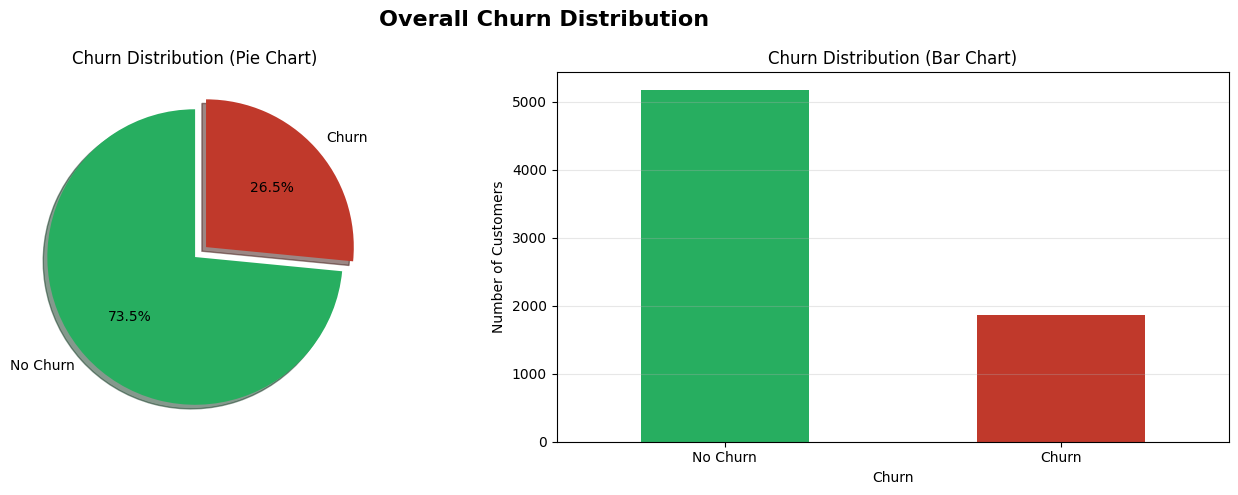

In [3]:
# =============================================================================
# CHURN ANALYSIS - ORGANIZED BY FEATURE TYPE
# =============================================================================

# Split churned vs retained
churn_data = data[data['Churn'] == 1]
no_churn_data = data[data['Churn'] == 0]

# ---------------------------
# SECTION 1: OVERALL CHURN
# ---------------------------
churn_counts = data['Churn'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Overall Churn Distribution', fontsize=16, fontweight='bold')

# Pie chart
axes[0].pie(churn_counts.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
            startangle=90, colors=COLORS, explode=(0, 0.1), shadow=True)
axes[0].set_title('Churn Distribution (Pie Chart)')

# Bar chart
churn_counts.plot(kind='bar', ax=axes[1], color=COLORS)
axes[1].set_title('Churn Distribution (Bar Chart)')
axes[1].set_xticks(range(len(churn_counts)))  # FIX: Add set_xticks first
axes[1].set_xticklabels(['No Churn', 'Churn'], rotation=0)
axes[1].set_ylabel('Number of Customers')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

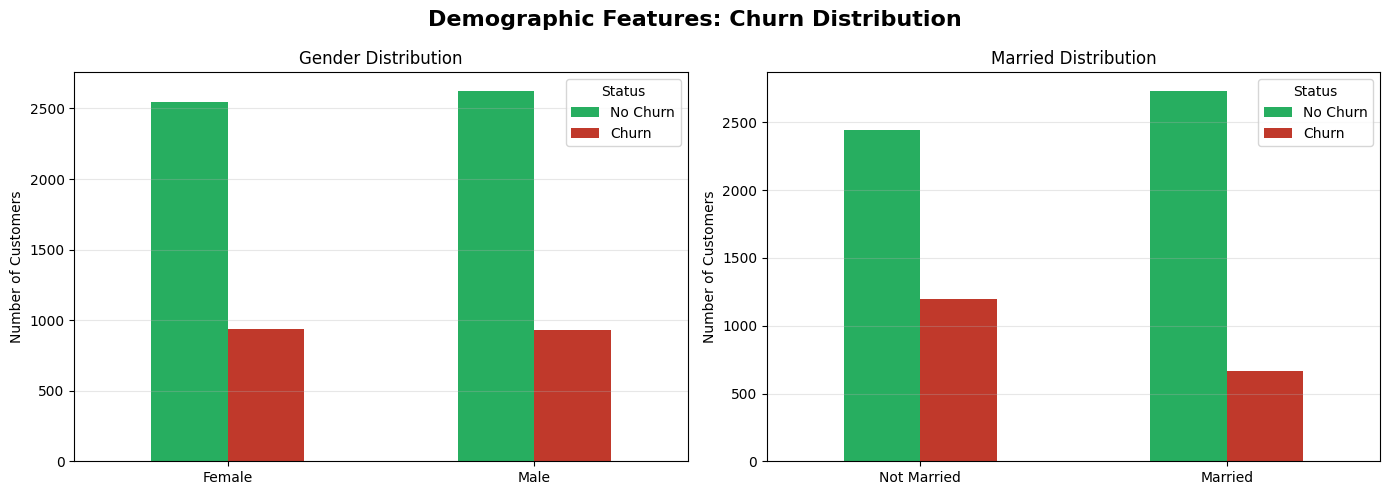

In [4]:
# ---------------------------
# SECTION 2: DEMOGRAPHIC FEATURES (CATEGORICAL)
# ---------------------------
demographic_categorical = {'Gender': {0: 'Female', 1: 'Male'},
                           'Married': {0: 'Not Married', 1: 'Married'}}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Demographic Features: Churn Distribution', fontsize=16, fontweight='bold')

for i, (feature, labels) in enumerate(demographic_categorical.items()):
    if feature in data.columns:
        churn_by_feature = data.groupby(feature)['Churn'].agg(['sum', 'count', 'mean'])
        df_plot = pd.DataFrame({
            'No Churn': [no_churn_data[feature].value_counts().get(idx, 0) for idx in labels.keys()],
            'Churn': [churn_data[feature].value_counts().get(idx, 0) for idx in labels.keys()]
        }, index=list(labels.values()))
        df_plot.plot(kind='bar', ax=axes[i], color=COLORS)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_ylabel('Number of Customers')
        axes[i].set_xticks(range(len(labels)))  # FIX: Add set_xticks
        axes[i].set_xticklabels(list(labels.values()), rotation=0)
        axes[i].legend(title='Status')
        axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Age: Churn mean=49.74, No churn mean=45.34, p=0.000000
NumberofDependents: Churn mean=0.12, No churn mean=0.60, p=0.000000
NumberofReferrals: Churn mean=0.52, No churn mean=2.47, p=0.000000
Population: Churn mean=23957.21, No churn mean=21483.03, p=0.000017


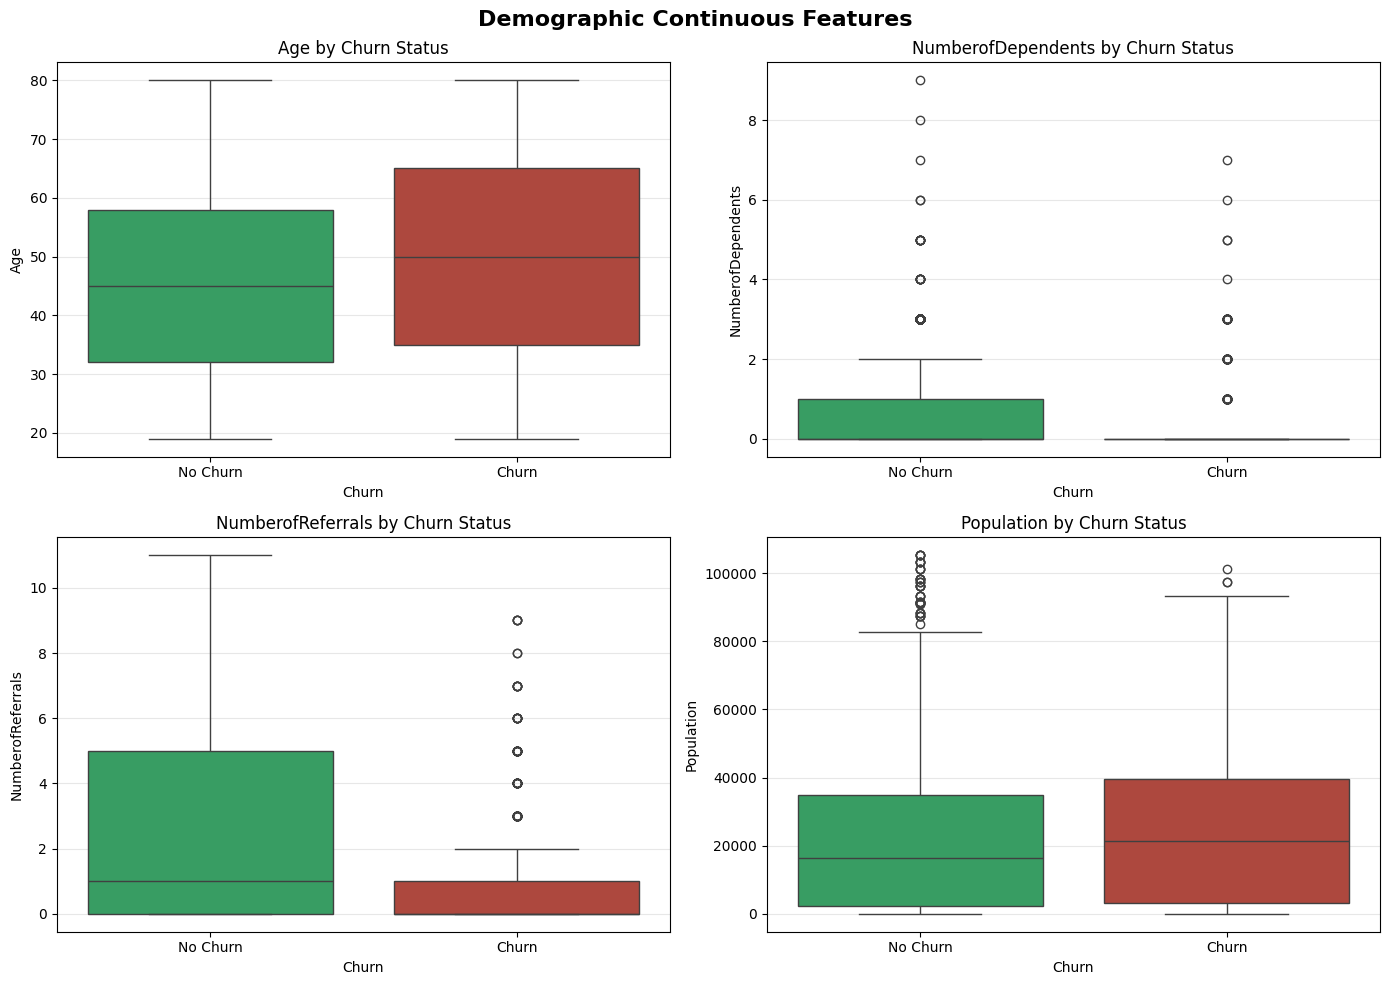

In [5]:

# ---------------------------
# SECTION 3: DEMOGRAPHIC FEATURES (CONTINUOUS)
# ---------------------------

demographic_continuous = ['Age', 'NumberofDependents', 'NumberofReferrals', 'Population']

for col in demographic_continuous:
    if col in data.columns:
        churn_vals = churn_data[col].dropna()
        nochurn_vals = no_churn_data[col].dropna()
        if len(churn_vals) > 1 and len(nochurn_vals) > 1:
            t_stat, p_value = stats.ttest_ind(churn_vals, nochurn_vals, equal_var=False)
            print(f"{col}: Churn mean={churn_vals.mean():.2f}, No churn mean={nochurn_vals.mean():.2f}, p={p_value:.6f}")

# Boxplots for continuous features - FIXED
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Demographic Continuous Features', fontsize=16, fontweight='bold')

for idx, col in enumerate(demographic_continuous):
    if col in data.columns:
        ax = axes[idx//2, idx%2]
        # FIX: Add hue='Churn', legend=False and set_xticks
        sns.boxplot(data=data, x='Churn', y=col, hue='Churn', ax=ax, palette=COLORS, legend=False)
        ax.set_xticks([0, 1])  # FIX: Add set_xticks before set_xticklabels
        ax.set_xticklabels(['No Churn', 'Churn'])
        ax.set_title(f'{col} by Churn Status')
        ax.grid(axis='y', alpha=0.3)

# Hide unused axes
if len(demographic_continuous) < 4:
    axes[1,1].axis('off')

plt.tight_layout()
plt.show()


SECTION 4: SERVICE FEATURES - CATEGORICAL (BINARY)

📊 CHURN RATES BY BINARY SERVICE FEATURES:
----------------------------------------------------------------------
Analyzing 12 binary service features...


InternetService:
   No Internet: 7.4% churn rate (113/1526 customers)
   Has Internet: 31.8% churn rate (1756/5517 customers)

PhoneService:
   No Phone: 24.9% churn rate (170/682 customers)
   Has Phone: 26.7% churn rate (1699/6361 customers)

MultipleLines:
   No Multiple Lines: 25.0% churn rate (1019/4072 customers)
   Has Multiple Lines: 28.6% churn rate (850/2971 customers)

OnlineSecurity:
   No: 31.3% churn rate (1574/5024 customers)
   Yes: 14.6% churn rate (295/2019 customers)

OnlineBackup:
   No: 29.2% churn rate (1346/4614 customers)
   Yes: 21.5% churn rate (523/2429 customers)

DeviceProtectionPlan:
   No: 28.7% churn rate (1324/4621 customers)
   Yes: 22.5% churn rate (545/2422 customers)

PremiumTechSupport:
   No: 31.2% churn rate (1559/4999 customers)
   Yes: 15.2%

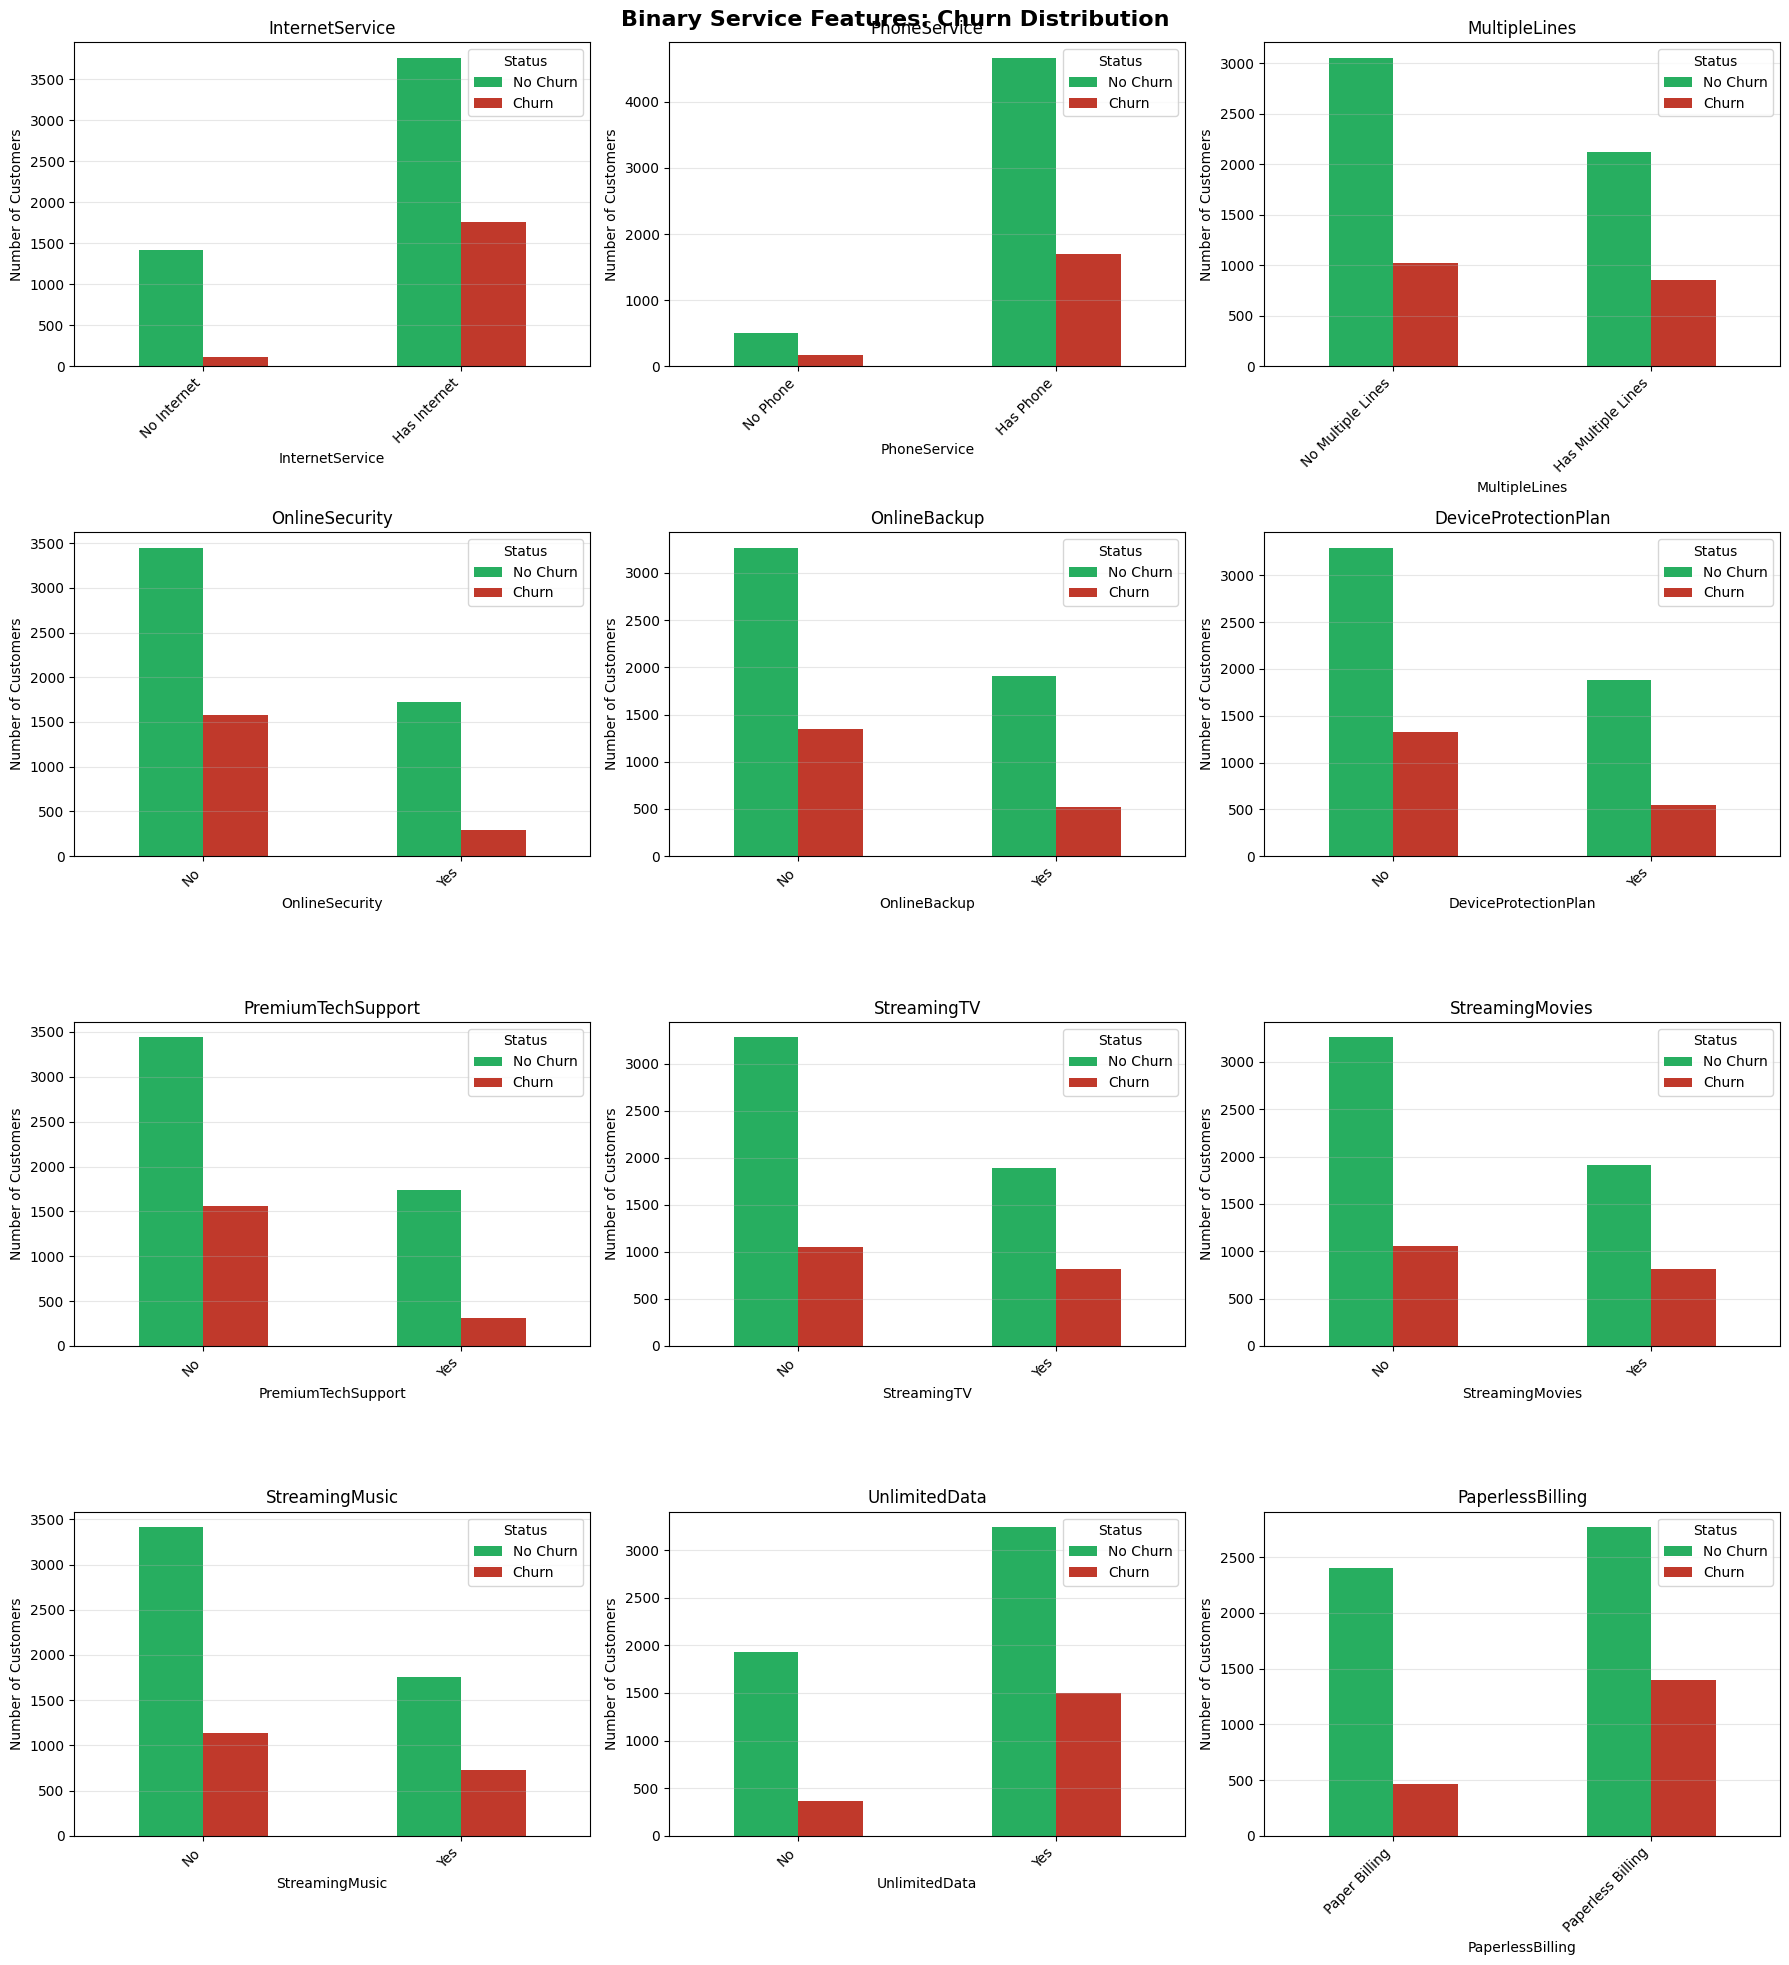


✅ Section 4 Complete



In [6]:
# =============================================================================
# SECTION 4: SERVICE FEATURES (CATEGORICAL - BINARY)
# =============================================================================

print("=" * 80)
print("SECTION 4: SERVICE FEATURES - CATEGORICAL (BINARY)")
print("=" * 80)

# Statistical Analysis
print("\n📊 CHURN RATES BY BINARY SERVICE FEATURES:")
print("-" * 70)

binary_service_features = {
    'InternetService': {0: 'No Internet', 1: 'Has Internet'},
    'PhoneService': {0: 'No Phone', 1: 'Has Phone'},
    'MultipleLines': {0: 'No Multiple Lines', 1: 'Has Multiple Lines'},
    'OnlineSecurity': {0: 'No', 1: 'Yes'},
    'OnlineBackup': {0: 'No', 1: 'Yes'},
    'DeviceProtectionPlan': {0: 'No', 1: 'Yes'},
    'PremiumTechSupport': {0: 'No', 1: 'Yes'},
    'StreamingTV': {0: 'No', 1: 'Yes'},
    'StreamingMovies': {0: 'No', 1: 'Yes'},
    'StreamingMusic': {0: 'No', 1: 'Yes'},
    'UnlimitedData': {0: 'No', 1: 'Yes'},
    'PaperlessBilling': {0: 'Paper Billing', 1: 'Paperless Billing'}
}

# Filter to features that exist in our data
existing_features = {k: v for k, v in binary_service_features.items() if k in data.columns}

print(f"Analyzing {len(existing_features)} binary service features...\n")

for feature, labels in existing_features.items():
    churn_by_feature = data.groupby(feature)['Churn'].agg(['sum', 'count', 'mean'])
    print(f"\n{feature}:")
    for idx, row in churn_by_feature.iterrows():
        label = labels.get(idx, idx)
        print(f"   {label}: {row['mean']:.1%} churn rate ({int(row['sum'])}/{int(row['count'])} customers)")

# Visualization: Binary Service Features
n_features = len(existing_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
fig.suptitle('Binary Service Features: Churn Distribution', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)
axes_flat = axes.flatten()

for idx, (feature, labels) in enumerate(existing_features.items()):
    if idx < len(axes_flat):
        ax = axes_flat[idx]

        # Get counts
        feature_churn = churn_data[feature].value_counts().sort_index()
        feature_nochurn = no_churn_data[feature].value_counts().sort_index()

        # Create DataFrame - handle missing indices
        max_idx = 1  # Binary features are 0 and 1
        feature_df = pd.DataFrame({
            'No Churn': [feature_nochurn.get(i, 0) for i in range(max_idx + 1)],
            'Churn': [feature_churn.get(i, 0) for i in range(max_idx + 1)]
        }, index=[labels.get(i, f'Value {i}') for i in range(max_idx + 1)])

        # Plot
        feature_df.plot(kind='bar', ax=ax, color=COLORS)
        ax.set_title(f'{feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Number of Customers')
        ax.set_xticks(range(len(feature_df.index)))
        ax.set_xticklabels(feature_df.index, rotation=45, ha='right')
        ax.legend(title='Status')
        ax.grid(axis='y', alpha=0.3)

# Hide any empty subplots
for idx in range(len(existing_features), n_rows * n_cols):
    axes_flat[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Section 4 Complete\n")

SECTION 5A: SERVICE FEATURES - CONTINUOUS

📊 STATISTICAL COMPARISON (CONTINUOUS FEATURES):
----------------------------------------------------------------------------------------------------
Feature                        Churn Mean      No-Churn Mean   Difference      p-value
----------------------------------------------------------------------------------------------------
TenureinMonths                 17.98           37.59           -19.61          0.000000 ***
MonthlyCharge                  73.35           60.07           13.27           0.000000 ***
TotalCharges                   1531.80         2550.79         -1019.00        0.000000 ***
AvgMonthlyLongDistanceCharges  23.17           22.88           0.28            0.495006 ns
AvgMonthlyGBDownload           22.18           19.92           2.26            0.000012 ***
TotalRefunds                   1.52            2.12            -0.60           0.002412 **
TotalExtraDataCharges          7.16            6.75            0.41   

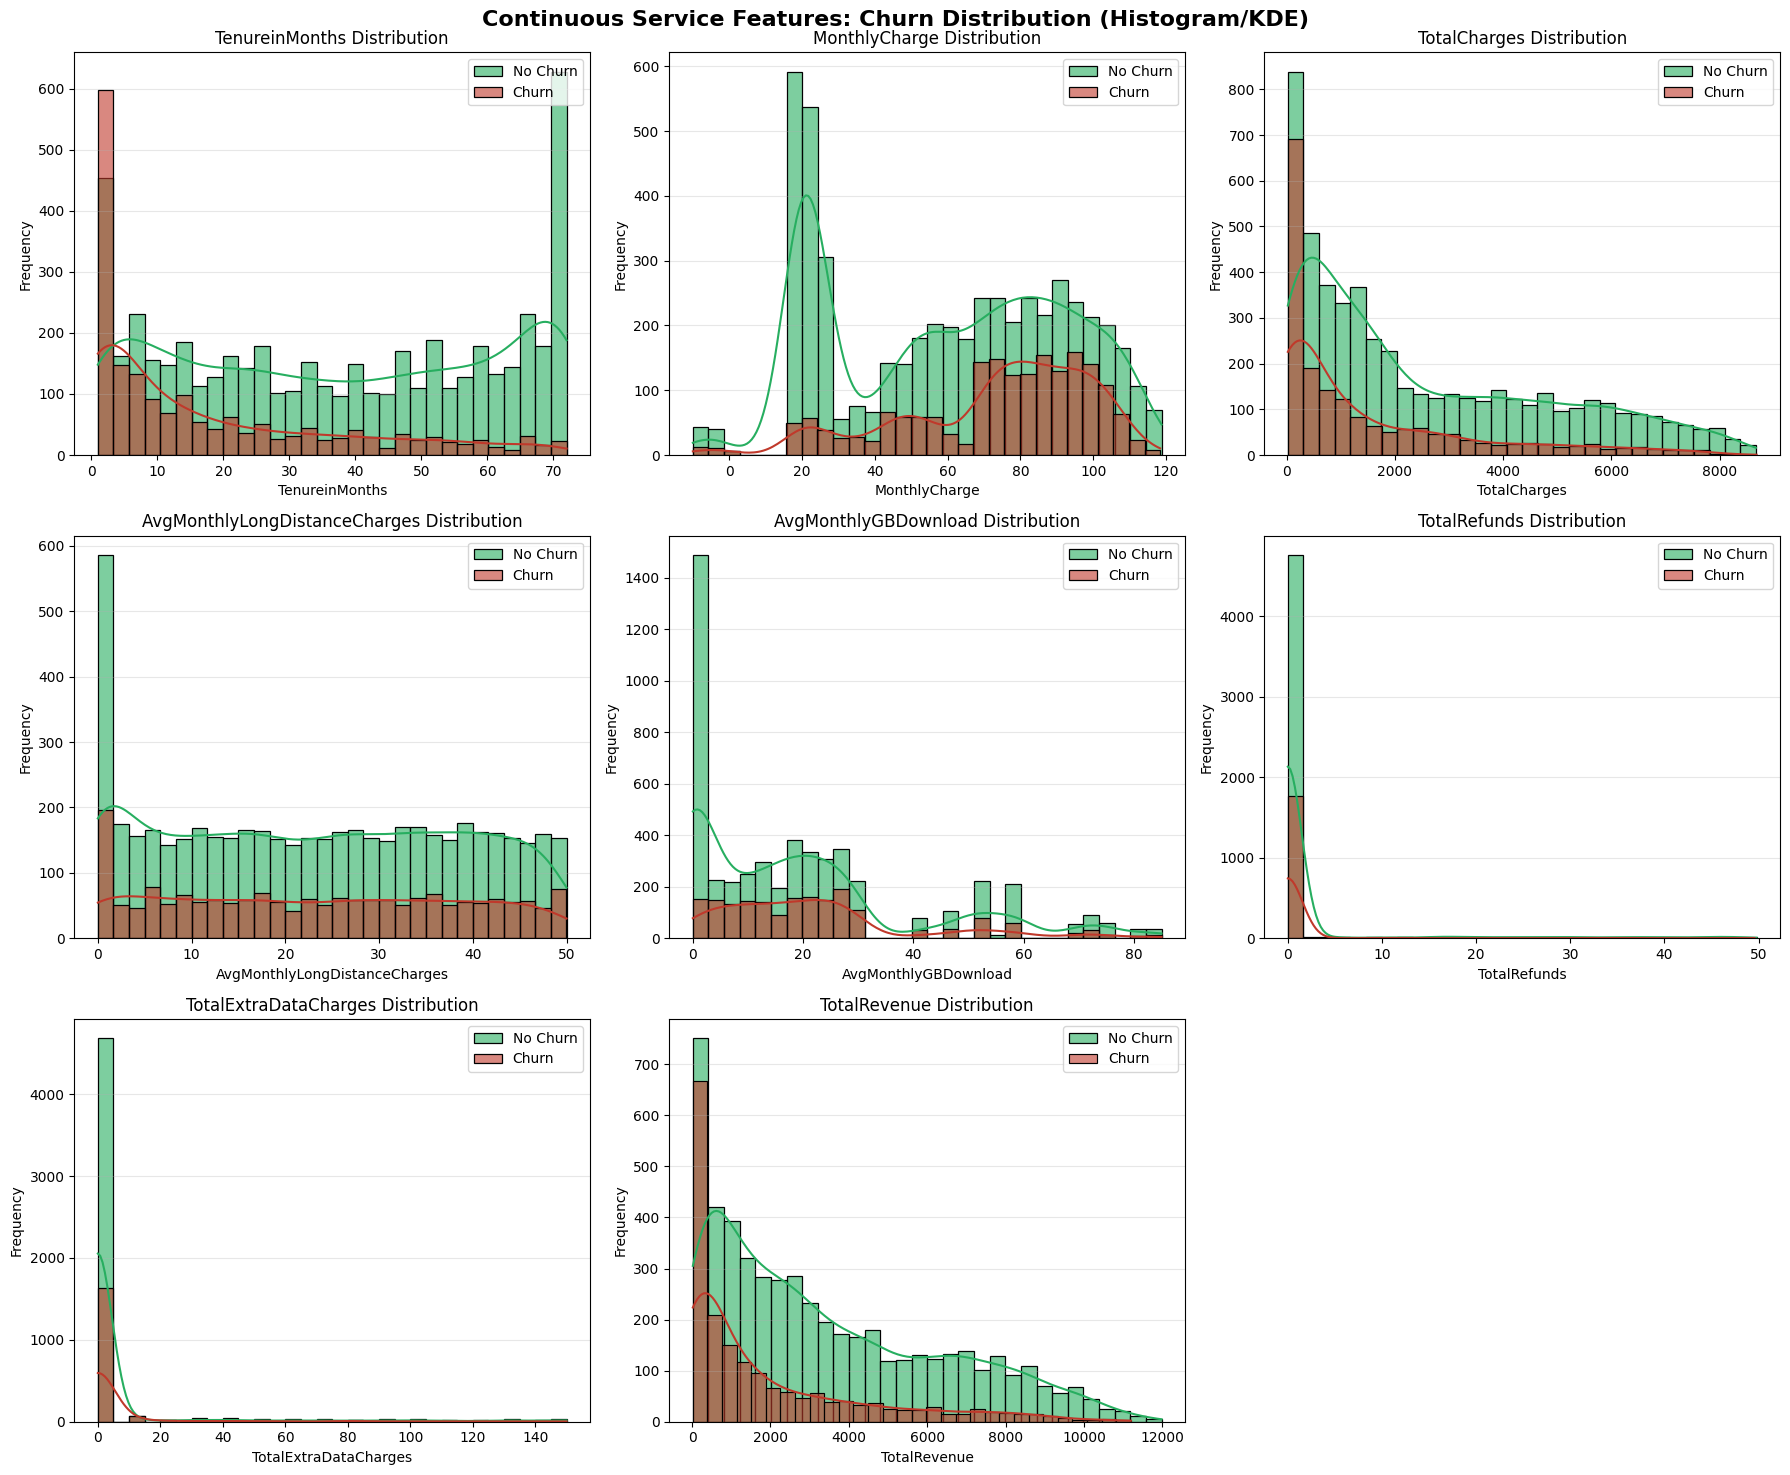

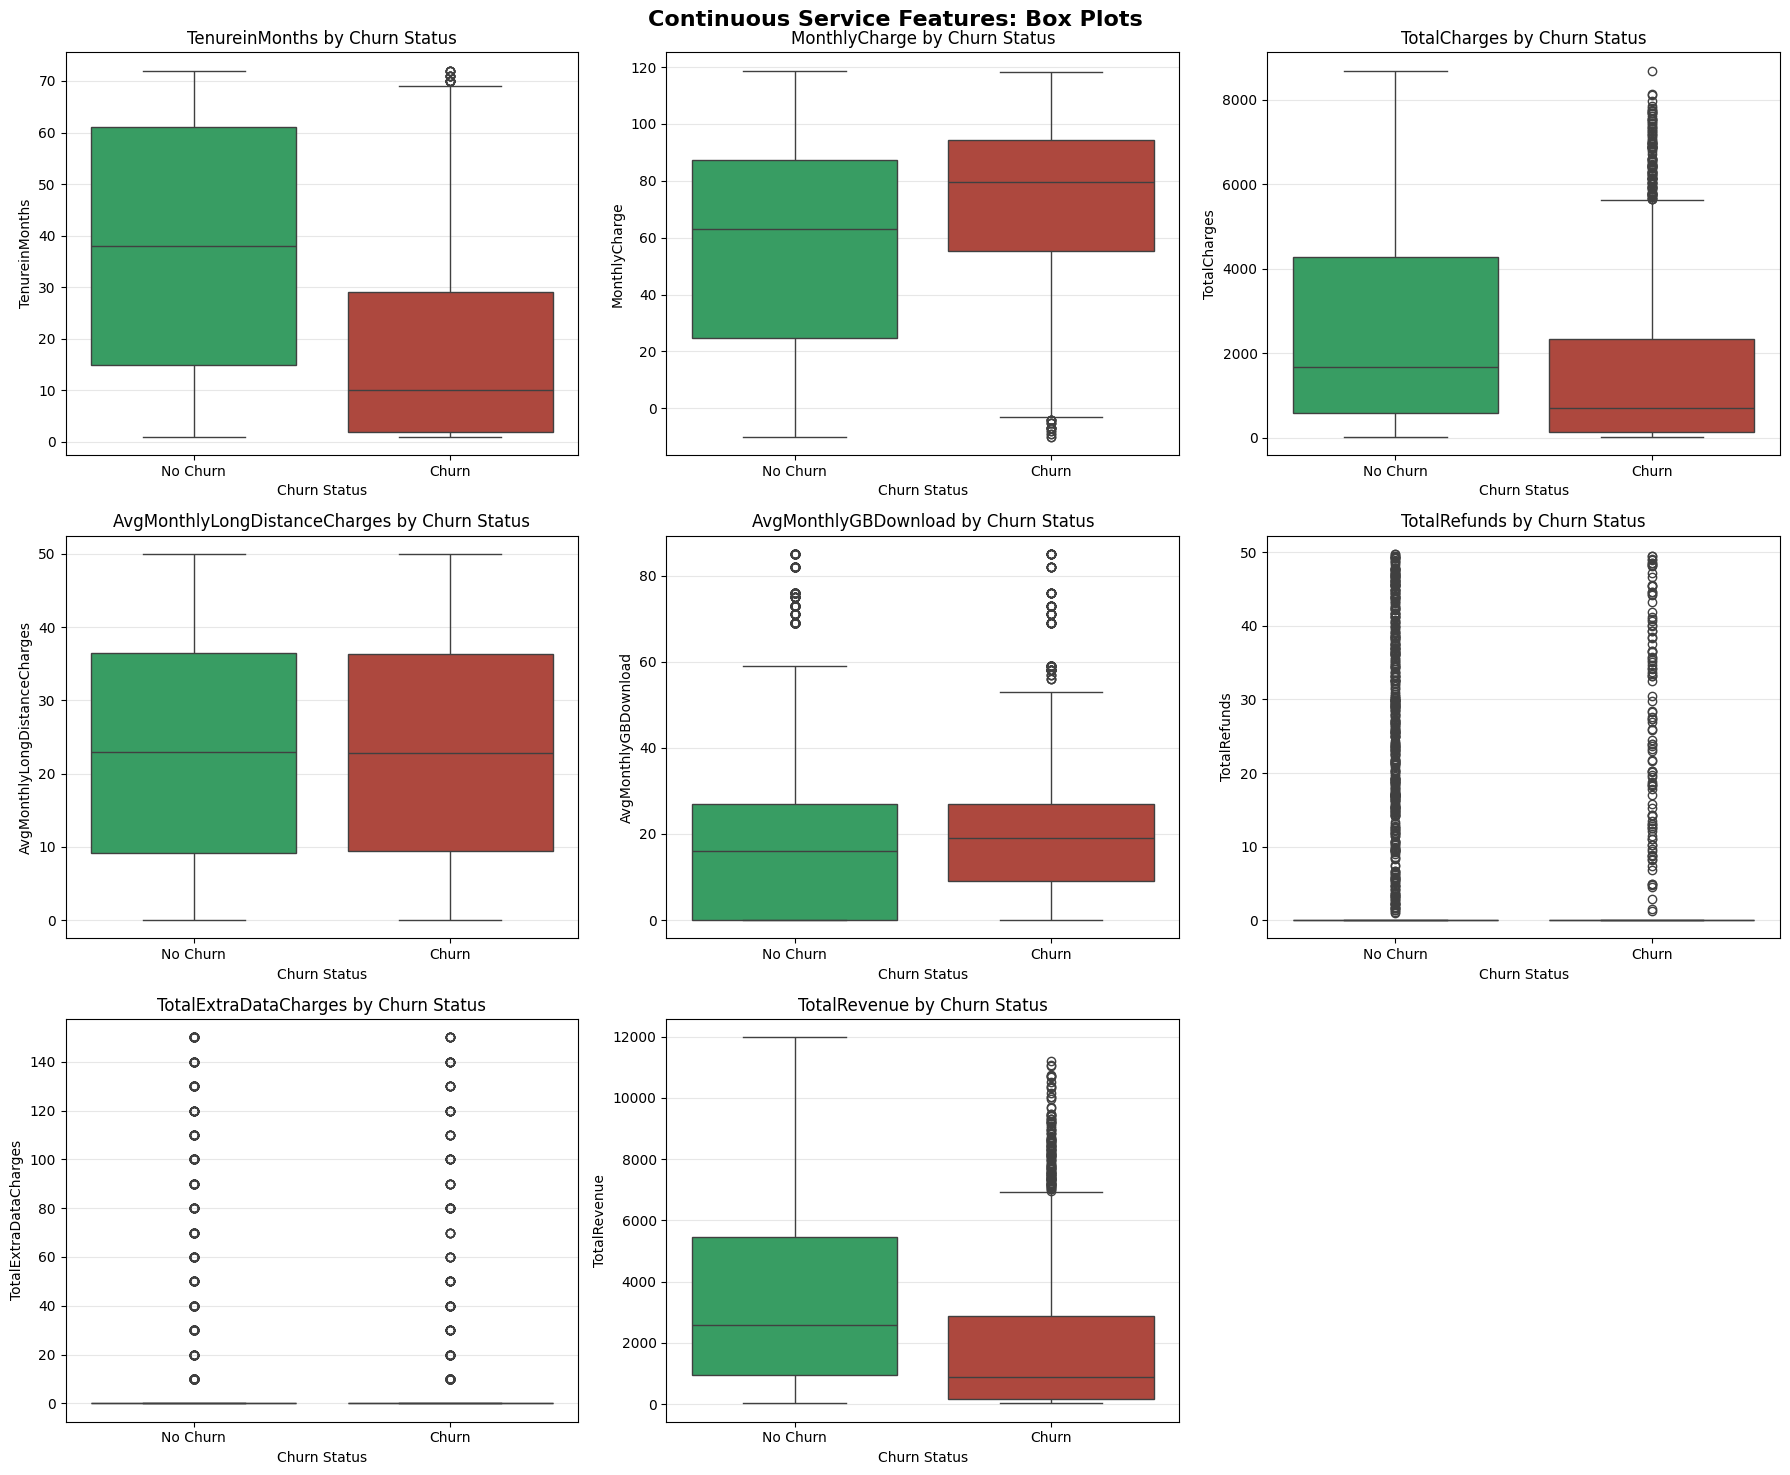


✅ Section 5A Complete



In [7]:
# =============================================================================
# SECTION 5A: SERVICE FEATURES (CONTINUOUS)
# =============================================================================

print("=" * 80)
print("SECTION 5A: SERVICE FEATURES - CONTINUOUS")
print("=" * 80)

continuous_features = [
    'TenureinMonths',
    'MonthlyCharge',
    'TotalCharges',
    'AvgMonthlyLongDistanceCharges',
    'AvgMonthlyGBDownload',
    'TotalRefunds',
    'TotalExtraDataCharges',
    'TotalRevenue'
]

# Filter to existing columns only
continuous_features = [col for col in continuous_features if col in data.columns]

# --- 1. Statistical Analysis ---
print("\n📊 STATISTICAL COMPARISON (CONTINUOUS FEATURES):")
print("-" * 100)
print(f"{'Feature':<30} {'Churn Mean':<15} {'No-Churn Mean':<15} {'Difference':<15} {'p-value'}")
print("-" * 100)

for col in continuous_features:
    churn_vals = churn_data[col].dropna()
    nochurn_vals = no_churn_data[col].dropna()

    if len(churn_vals) > 1 and len(nochurn_vals) > 1:
        # T-test for independent samples
        t_stat, p_value = stats.ttest_ind(churn_vals, nochurn_vals, equal_var=False)
        churn_mean = churn_vals.mean()
        nochurn_mean = nochurn_vals.mean()
        difference = churn_mean - nochurn_mean
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'

        print(f"{col:<30} {churn_mean:<15.2f} {nochurn_mean:<15.2f} {difference:<15.2f} {p_value:.6f} {significance}")

# --- 2. Visualization: Distribution (Histogram with KDE) ---
n_features = len(continuous_features)
n_cols = 3
n_rows_dist = (n_features + n_cols - 1) // n_cols # Ceiling division for rows

fig_dist, axes_dist = plt.subplots(n_rows_dist, n_cols, figsize=(18, n_rows_dist * 5))
fig_dist.suptitle('Continuous Service Features: Churn Distribution (Histogram/KDE)', fontsize=16, fontweight='bold')

# Ensure axes is a 2D array even for a single row
if n_rows_dist == 1:
    axes_dist = axes_dist.reshape(1, -1)
elif n_cols == 1:
    axes_dist = axes_dist.reshape(-1, 1)

for idx, col in enumerate(continuous_features):
    row = idx // n_cols
    col_pos = idx % n_cols

    # Plotting No Churn distribution
    sns.histplot(data=no_churn_data, x=col, label='No Churn', alpha=0.6,
                 ax=axes_dist[row, col_pos], color=NO_CHURN_COLOR, kde=True, bins=30,
                 line_kws={'linewidth': 1.5}) # Added line_kws for slightly thicker KDE line

    # Plotting Churn distribution
    sns.histplot(data=churn_data, x=col, label='Churn', alpha=0.6,
                 ax=axes_dist[row, col_pos], color=CHURN_COLOR, kde=True, bins=30,
                 line_kws={'linewidth': 1.5})

    axes_dist[row, col_pos].set_title(f'{col} Distribution')
    axes_dist[row, col_pos].set_xlabel(col)
    axes_dist[row, col_pos].set_ylabel('Frequency')
    axes_dist[row, col_pos].legend(loc='upper right')
    axes_dist[row, col_pos].grid(axis='y', alpha=0.3)

# Hide any empty subplots
for idx in range(len(continuous_features), n_rows_dist * n_cols):
    row = idx // n_cols
    col_pos = idx % n_cols
    axes_dist[row, col_pos].axis('off')

plt.tight_layout()
plt.show()


# --- 3. Visualization: Boxplots (The existing code block) ---
n_features = len(continuous_features)
n_cols = 3
n_rows_box = (n_features + n_cols - 1) // n_cols # Ceiling division for rows

fig_box, axes_box = plt.subplots(n_rows_box, n_cols, figsize=(18, n_rows_box * 5))
fig_box.suptitle('Continuous Service Features: Box Plots', fontsize=16, fontweight='bold')

if n_rows_box == 1:
    axes_box = axes_box.reshape(1, -1)
elif n_cols == 1:
    axes_box = axes_box.reshape(-1, 1)

for idx, col in enumerate(continuous_features):
    row = idx // n_cols
    col_pos = idx % n_cols

    sns.boxplot(data=data, x='Churn', y=col, hue='Churn', ax=axes_box[row, col_pos],
                palette=COLORS, legend=False)
    axes_box[row, col_pos].set_title(f'{col} by Churn Status')
    axes_box[row, col_pos].set_xticks([0, 1])
    axes_box[row, col_pos].set_xticklabels(['No Churn', 'Churn'])
    axes_box[row, col_pos].set_xlabel('Churn Status')
    axes_box[row, col_pos].set_ylabel(col)
    axes_box[row, col_pos].grid(axis='y', alpha=0.3)

# Hide any empty subplots
for idx in range(len(continuous_features), n_rows_box * n_cols):
    row = idx // n_cols
    col_pos = idx % n_cols
    axes_box[row, col_pos].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Section 5A Complete\n")

SECTION 5B: SERVICE FEATURES - ORDINAL

📊 CHURN RATES BY ORDINAL FEATURES:
----------------------------------------------------------------------

Contract:
   Month-to-Month: 45.8% churn rate (1655/3610 customers)
   One Year: 10.7% churn rate (166/1550 customers)
   Two Year: 2.5% churn rate (48/1883 customers)

PaymentMethod:
   Bank Withdrawal: 34.0% churn rate (1329/3909 customers)
   Credit Card: 14.5% churn rate (398/2749 customers)
   Mailed Check: 36.9% churn rate (142/385 customers)

InternetType:
   No Internet: 7.4% churn rate (113/1526 customers)
   DSL: 18.6% churn rate (307/1652 customers)
   Cable: 25.7% churn rate (213/830 customers)
   Fiber Optic: 40.7% churn rate (1236/3035 customers)

Offer:
   No Offer: 27.1% churn rate (1051/3877 customers)
   Offer A: 6.7% churn rate (35/520 customers)
   Offer B: 12.3% churn rate (101/824 customers)
   Offer C: 22.9% churn rate (95/415 customers)
   Offer D: 26.7% churn rate (161/602 customers)
   Offer E: 52.9% churn rate (426

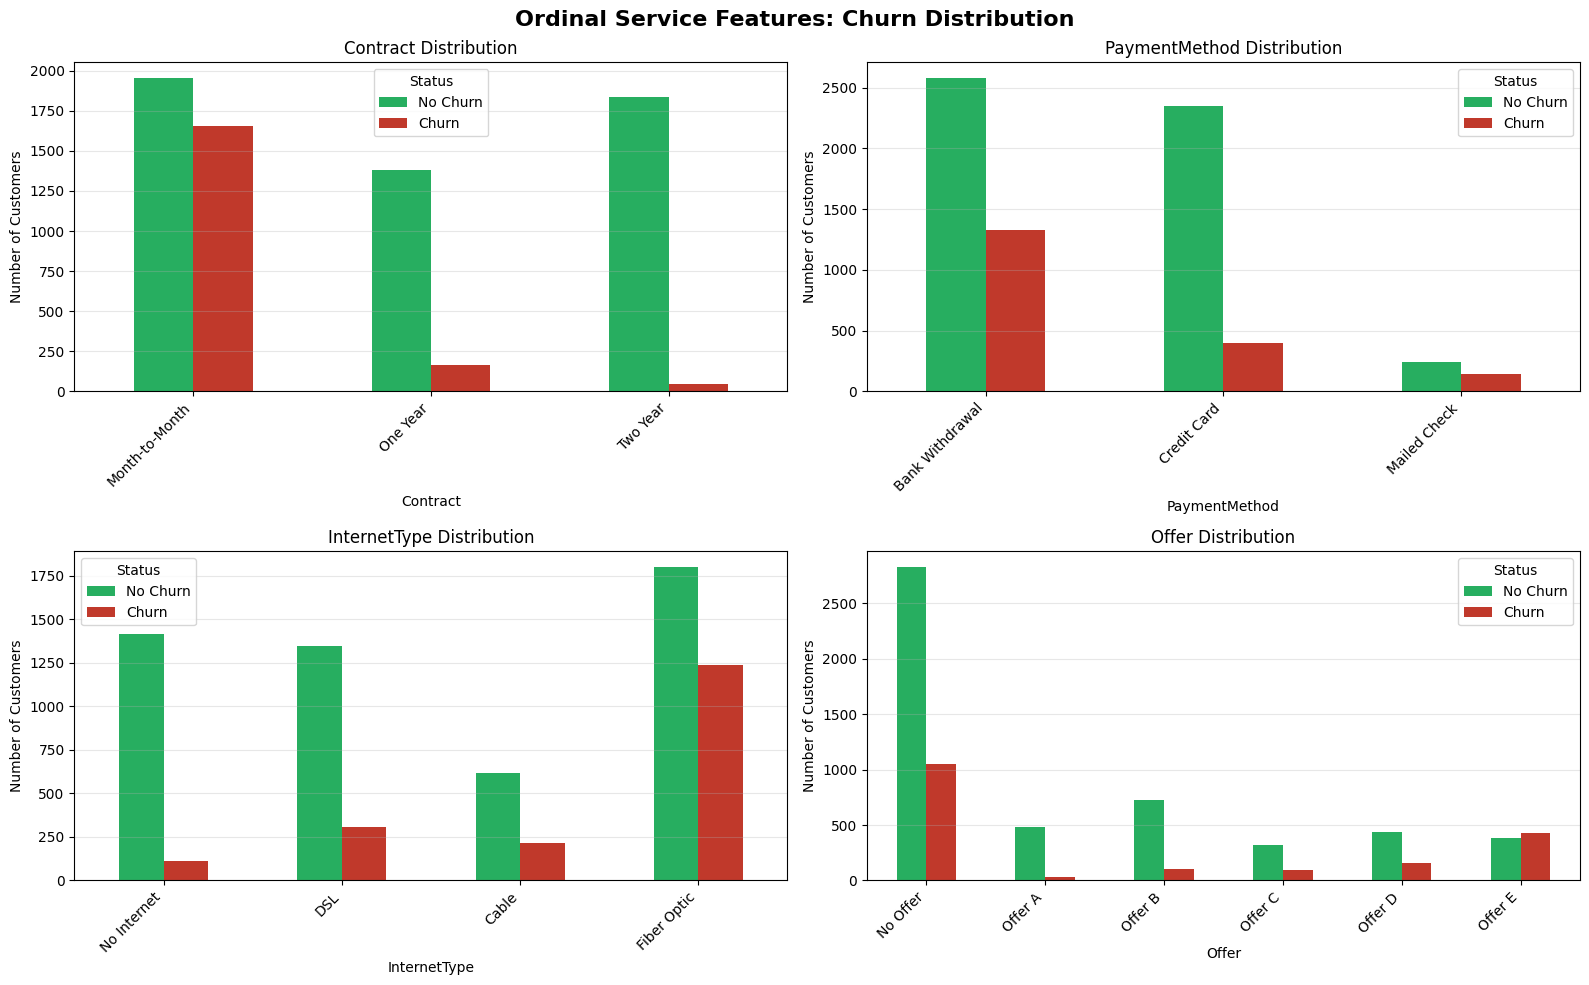


✅ Section 5B Complete



In [8]:
# =============================================================================
# SECTION 5B: SERVICE FEATURES (ORDINAL)
# =============================================================================

print("=" * 80)
print("SECTION 5B: SERVICE FEATURES - ORDINAL")
print("=" * 80)

ordinal_features = {
    'Contract': {0: 'Month-to-Month', 1: 'One Year', 2: 'Two Year'},
    'PaymentMethod': {0: 'Bank Withdrawal', 1: 'Credit Card', 2: 'Mailed Check'},
    'InternetType': {0: 'No Internet', 1: 'DSL', 2: 'Cable', 3: 'Fiber Optic'},
    'Offer': {0: 'No Offer', 1: 'Offer A', 2: 'Offer B', 3: 'Offer C', 4: 'Offer D', 5: 'Offer E'}
}

# Statistical Analysis
print("\n📊 CHURN RATES BY ORDINAL FEATURES:")
print("-" * 70)

for feature, labels in ordinal_features.items():
    if feature in data.columns:
        churn_by_feature = data.groupby(feature)['Churn'].agg(['sum', 'count', 'mean'])
        print(f"\n{feature}:")
        for idx, row in churn_by_feature.iterrows():
            label = labels.get(idx, f'Unknown ({idx})')
            print(f"   {label}: {row['mean']:.1%} churn rate ({int(row['sum'])}/{int(row['count'])} customers)")

# Visualization: Ordinal Features Bar Charts
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Ordinal Service Features: Churn Distribution', fontsize=16, fontweight='bold')

for idx, (feature, labels) in enumerate(ordinal_features.items()):
    if feature in data.columns:
        row = idx // 2
        col = idx % 2

        # Get counts
        feature_churn = churn_data[feature].value_counts().sort_index()
        feature_nochurn = no_churn_data[feature].value_counts().sort_index()

        # Create DataFrame with correct labels
        max_idx = max(labels.keys())
        feature_df = pd.DataFrame({
            'No Churn': [feature_nochurn.get(i, 0) for i in range(max_idx + 1)],
            'Churn': [feature_churn.get(i, 0) for i in range(max_idx + 1)]
        }, index=[labels.get(i, f'Cat {i}') for i in range(max_idx + 1)])

        # Plot
        feature_df.plot(kind='bar', ax=axes[row, col], color=COLORS)
        axes[row, col].set_title(f'{feature} Distribution')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Number of Customers')
        axes[row, col].set_xticks(range(len(feature_df.index)))
        axes[row, col].set_xticklabels(feature_df.index, rotation=45, ha='right')
        axes[row, col].legend(title='Status')
        axes[row, col].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Section 5B Complete\n")

SECTION 10: CORRELATION ANALYSIS

📊 TOP FEATURES CORRELATED WITH CHURN:
----------------------------------------------------------------------

Top 15 Positive Correlations with Churn:
   InternetType: 0.303
   InternetService: 0.228
   PaperlessBilling: 0.192
   MonthlyCharge: 0.188
   UnlimitedData: 0.167
   Offer: 0.120
   Age: 0.116
   StreamingTV: 0.063
   StreamingMovies: 0.061
   Population: 0.052
   AvgMonthlyGBDownload: 0.049
   StreamingMusic: 0.046
   MultipleLines: 0.040
   PhoneService: 0.012
   AvgMonthlyLongDistanceCharges: 0.008

Top 15 Negative Correlations with Churn:
   Contract: -0.435
   TenureinMonths: -0.353
   NumberofReferrals: -0.287
   TotalLongDistanceCharges: -0.224
   TotalRevenue: -0.223
   NumberofDependents: -0.219
   TotalCharges: -0.199
   OnlineSecurity: -0.171
   PremiumTechSupport: -0.165
   Married: -0.150
   PaymentMethod: -0.135
   OnlineBackup: -0.082
   DeviceProtectionPlan: -0.066
   TotalRefunds: -0.034
   Gender: -0.009


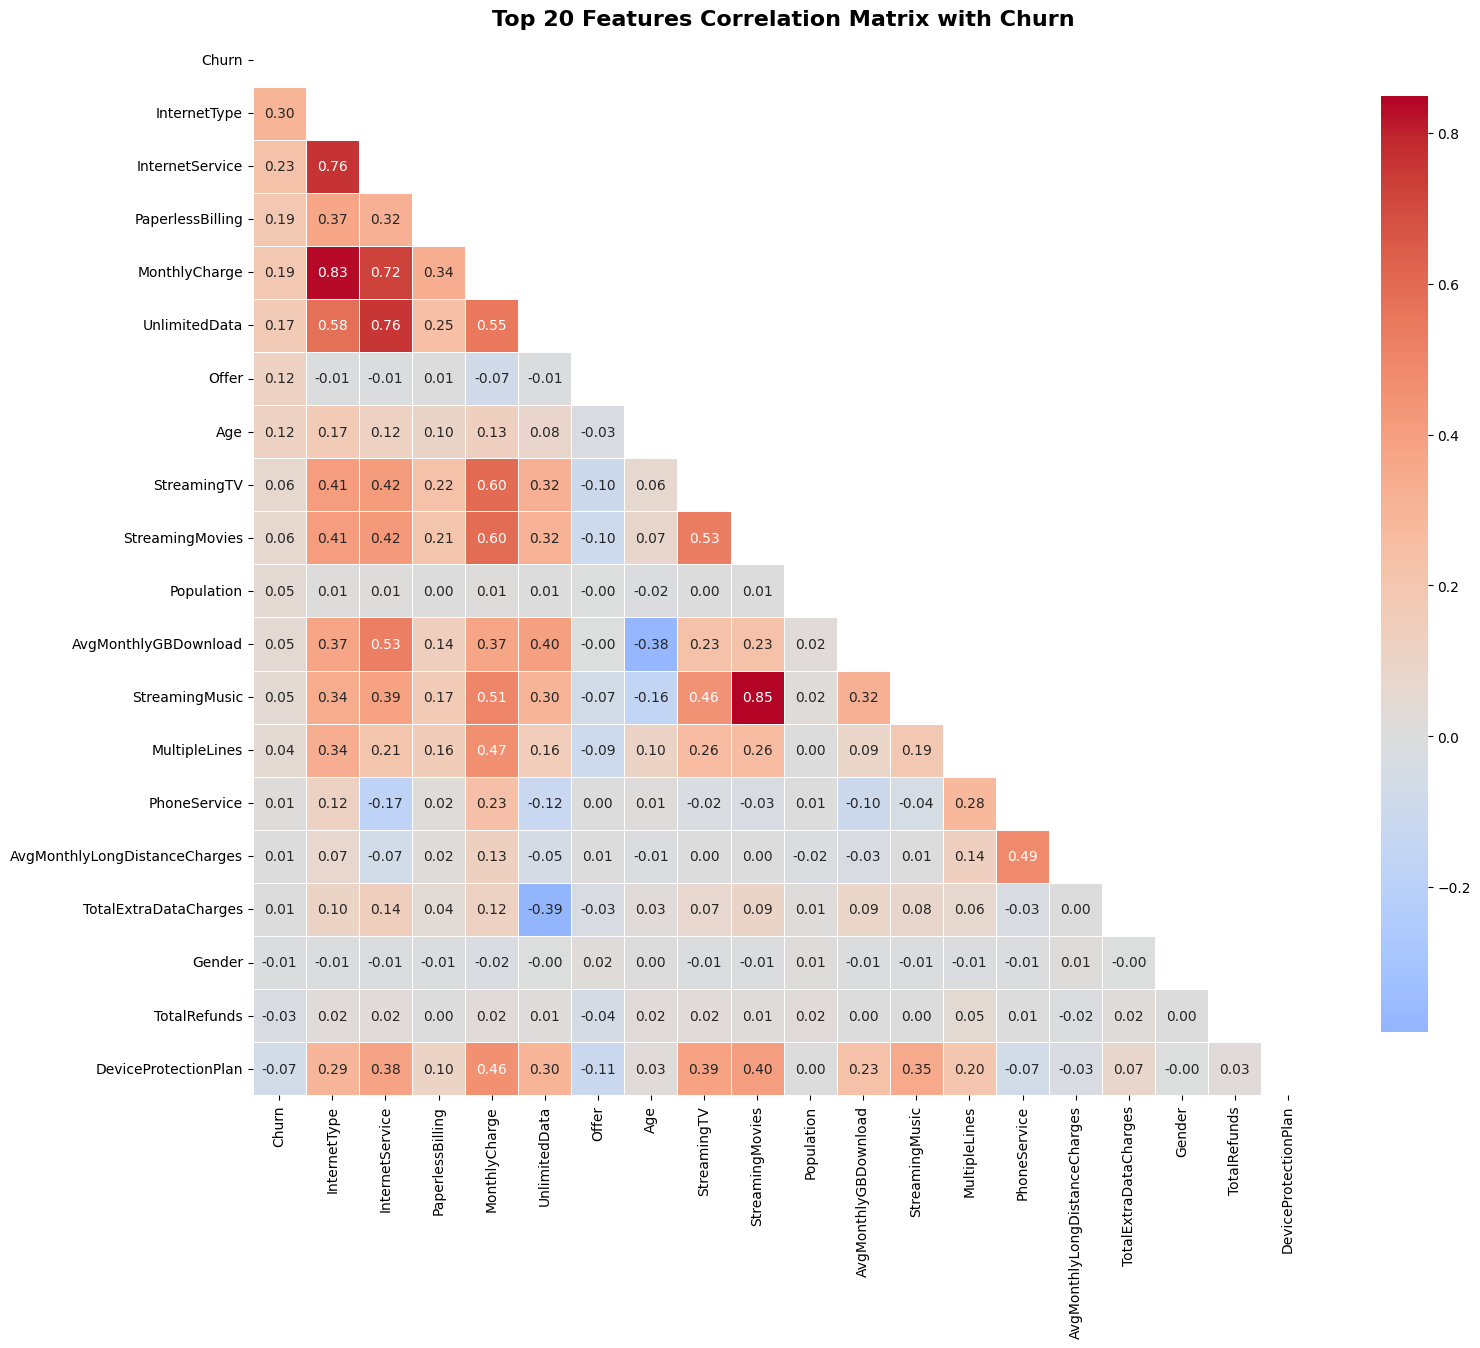


✅ Section 10 Complete



In [9]:
# =============================================================================
# SECTION 10: CORRELATION ANALYSIS
# =============================================================================

print("=" * 80)
print("SECTION 10: CORRELATION ANALYSIS")
print("=" * 80)

# Calculate correlation matrix
print("\n📊 TOP FEATURES CORRELATED WITH CHURN:")
print("-" * 70)

# Select numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' in numeric_cols:
    corr_matrix = data[numeric_cols].corr()
    churn_corr = corr_matrix['Churn'].sort_values(ascending=False)

    # Display top 15 positive and negative correlations
    print("\nTop 15 Positive Correlations with Churn:")
    for feature, corr_value in churn_corr[1:16].items():
        print(f"   {feature}: {corr_value:.3f}")

    print("\nTop 15 Negative Correlations with Churn:")
    for feature, corr_value in churn_corr[-15:].sort_values().items():
        print(f"   {feature}: {corr_value:.3f}")

# Visualization: Correlation Heatmap
plt.figure(figsize=(16, 14))
corr_matrix_top = data[churn_corr.head(20).index.tolist()].corr()
mask = np.triu(np.ones_like(corr_matrix_top, dtype=bool))
sns.heatmap(corr_matrix_top, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Top 20 Features Correlation Matrix with Churn', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Section 10 Complete\n")
